# interrupting and continuing of a simulation with a candidate Vector

In this example the simulation uses a `candidateVector`, a predefined set of candidates, as source. The test simulation is a simple 1D propagation of particles in the energy range of $10^{17} eV$ to $10^{21} eV$. The candidates are order in energy, for an easier overview of the state of the simulation. No other propagation effects are considered. 

Two sets of simulation, one full simulation and one which is interrupted and continued, are compared. The candidate ID will be used as continues number to check, that all candidates are reaching the final observer and nothing is lost. 

In [1]:
from crpropa import * 
import numpy as np 
import os 
from multiprocessing import cpu_count

## simulation setup

The candidate energies are the same for both simulation cases (with / without interrupting). 

In [2]:
# create candidate vector with increasing energies
lg_E_min = 17
lg_E_max = 21
lgE = np.random.uniform(lg_E_min, lg_E_max, 100_000)
lgE.sort()

In [3]:
def init_candidate_vector():
    """ initilize the candidate vector. Has to be done before every simulation. """
    cv = CandidateVector()
    for i, _e in enumerate(lgE): 
        c = Candidate(i, 10**_e * eV, Vector3d(1 * Gpc, 0, 0), Vector3d(-1, 0, 0)) 
        cv.push_back(CandidateRefPtr(c))
    return cv

### full simulation (no interruption)

In [4]:
# general setup 
def get_sim(filename):
    """ returns a modulelist to ensure running the same modules in each case """
    
    sim = ModuleList() 
    sim.add(SimplePropagation(1 * kpc, 10 * kpc)) # choose small steps to ensure long simulations 

    obs = Observer() 
    obs.add(Observer1D())
    out = TextOutput(filename) 
    obs.onDetection(out) 
    sim.add(obs)

    sim.setShowProgress(True)
    return sim, out

os.makedirs("cand_vector", exist_ok=True)
sim, out = get_sim("cand_vector/full.txt") 
cv = init_candidate_vector()
sim.run(cv)
out.close()

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Sep  5 12:28:34 2024 : [ Finished ] 100%    Needed: 00:00:48  - Finished at Thu Sep  5 12:29:22 2024


### simulation with interruption

This simulation is interrupted after some time. This process has to be done manually.

In [5]:
sim, out = get_sim("cand_vector/interrupted.txt")

out_interrupt = TextOutput("cand_vector/on_interruption.txt")
sim.setInterruptAction(out_interrupt)

sim.setShowProgress(True) 
cv = init_candidate_vector()
sim.run(cv)

crpropa::ModuleList: Number of Threads: 12
Run ModuleList


crpropa::ModuleList: Signal 2 (SIGINT/SIGTERM) received
############################################################################
#	Interrupted CRPropa simulation 
# in total 58477 Candidates have not been started.
# the indicies of the vector haven been written to to output file. 
############################################################################


KeyboardInterrupt: 

In [6]:
out.close() # closing the output file to avoid data loss 

### reloading and reruning the simulation

In [7]:
# load candidates from interrupted simulation 

file = "cand_vector/on_interruption.txt"
pc = ParticleCollector() 
pc.load(file)

# expected size of particles should be equal to the number of cores 
assert pc.size() <= cpu_count() , f"the number of loaded particles ({pc.size()}) must be lower or equal to the number of cores ({cpu_count()})"

# load indicies of not started candidates
with open(file, "r") as f: 
    line = f.readlines()[-1]
    indices = np.array(line.strip("\n").split("\t")[1:-1], dtype= int)

print("number of indices read from file:", len(indices))

number of indices read from file: 58477


In [8]:
# create a new candidate vector with the missing particles 
cv_new = pc.getContainer()
cv = init_candidate_vector()
for i, c in enumerate(cv): 
    if i in indices: 
        # accept candidates which were not started
        cv_new.push_back(c)

In [9]:
# run the simulation with the missing candidates 
sim, out = get_sim("cand_vector/continued.txt")
sim.run(cv_new)
out.close()

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Sep  5 12:30:00 2024 : [ Finished ] 100%    Needed: 00:00:30  - Finished at Thu Sep  5 12:30:30 2024


## read data from different simulations

The data from both simulation sets are loaded and compared

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt 

def read_crp(filename): 
    """ read a crpropa output file """
    
    with open(filename) as f: 
        names = f.readline().strip("\n").split("\t")[1:]
    
    return pd.read_csv(filename, names = names, delimiter = "\t", comment="#")

In [11]:
df_full = read_crp("cand_vector/full.txt")
df_first_half = read_crp("cand_vector/interrupted.txt")
df_second_half = read_crp("cand_vector/continued.txt")
print(f"the splited simulation has the length of {len(df_first_half)} and {len(df_second_half)}")

the splited simulation has the length of 41518 and 58482


### check ID number of particles 

Checking that both simulation outputs contain all particles. The particle ID is the number of the particles in the orignial candidate vector.

In [12]:
id_list_full = list(df_full.ID)
id_list_full.sort() 
assert np.all(id_list_full == np.arange(100_000))

In [13]:
id_list_continued = list(df_first_half.ID) + list(df_second_half.ID)
id_list_continued.sort() 
assert np.all(id_list_continued == np.arange(100_000))

### energy distribution of the arriving particles

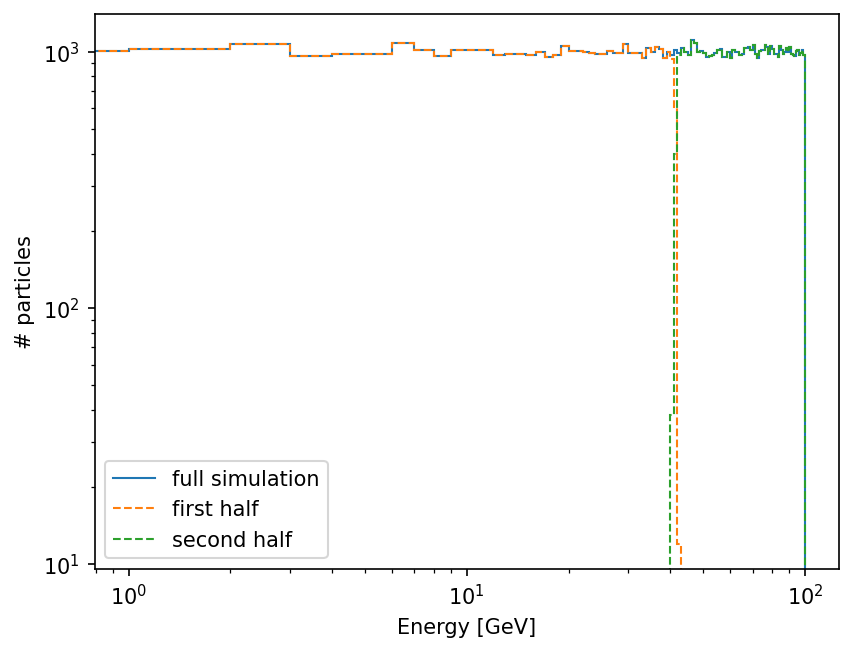

In [14]:
e_bins = np.logspace(-1, 3, 101) # in EeV as default output unit 
dE = np.diff(e_bins) 

dNdE_full = np.histogram(df_full.E, bins = e_bins)[0] 
dNdE_first = np.histogram(df_first_half.E, e_bins)[0] 
dNdE_second = np.histogram(df_second_half.E, e_bins)[0]
assert np.all(dNdE_full == (dNdE_first + dNdE_second))

plt.figure(dpi = 150) 
plt.stairs(dNdE_full, label = "full simulation")
plt.stairs(dNdE_first, label = "first half", ls = "--")
plt.stairs(dNdE_second, label = "second half", ls = "--")
plt.loglog()
plt.legend()
plt.ylabel("# particles")
plt.xlabel("Energy [GeV]")
plt.show()